### ISIC 2024 - Skin Cancer Detection with 3D-TBP
We have chosen the ISIC 2024 - Skin Cancer Detection task with 3D-TBP as our project. The problem and dataset we used can be found here: ISIC 2024 Challenge on Kaggle.

***Overview:***
Our approach begins by loading the necessary data, converting it into the appropriate format, and scaling it accordingly. We then set up a data generator, build the model, perform hyperparameter optimization, and evaluate the results. Detailed explanations and the corresponding code are provided below.

First we do the necessary imports:

# You need to run these cells until told otherwise

In [1]:
import tensorflow as tf
keras = tf.keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0



from kerastuner import Hyperband
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
import h5py
!pip install gdown
import gdown
import random
import shutil
import zipfile
import seaborn as sns
from PIL import Image
from joblib import dump, load

/tmp/ipykernel_23/4238377492.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import Hyperband
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


This code automates the process of downloading, extracting, and organizing the ISIC 2024 skin cancer dataset for use in our solution. First, it installs the Kaggle API and uses it to download the dataset. After downloading, the code extracts the ZIP file containing the data. It then processes the image data by reading the metadata and rearranging the images into two folders: 'benign' and 'malignant' based on the target label. This preprocessing step is essential as it prepares the dataset in a structured way, ensuring the images are correctly categorized for training and evaluation in our model.

In [ ]:
# Install Kaggle API
!pip install kaggle

# Download the dataset
!mkdir -p ~/.kaggle
!echo '{"username":"YOUR_API_NAME","key":"YOUR_API_KEY"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c isic-2024-challenge

# Extract the ZIP file
zip_file_path = 'isic-2024-challenge.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')


# Define paths
hdf5_file_path = 'dataset/train-image.hdf5'
metadata_file_path = 'dataset/train-metadata.csv'
image_folder = 'images'
folder1_name = 'benign'
folder2_name = 'malignant'
target_column = 'target'

# Create folders
os.makedirs(os.path.join(image_folder, folder1_name), exist_ok=True)
os.makedirs(os.path.join(image_folder, folder2_name), exist_ok=True)

# Process images
with h5py.File(hdf5_file_path, 'r') as hdf5_file:
    metadata_df = pd.read_csv(metadata_file_path)
    for _, row in metadata_df.iterrows():
        isic_id = row['isic_id']
        target_value = row[target_column]
        image_data = hdf5_file[isic_id][()]
        image = Image.open(io.BytesIO(image_data))
        destination_folder = folder1_name if target_value == 0 else folder2_name
        image_path = os.path.join(image_folder, destination_folder, f"{isic_id}.jpg")
        image.save(image_path)


print("Process complete and rearranged images zipped!")


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


 99%|█████████████████████████████████████▌| 1.98G/2.00G [00:20<00:00, 89.4MB/s]
100%|███████████████████████████████████████| 2.00G/2.00G [00:20<00:00, 104MB/s]


/tmp/ipykernel_23/2636225511.py:30: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(metadata_file_path)


Process complete and rearranged images zipped!


The code below selects 10% of the images from each dataset category and moves them into new directories labeled with "_test." This step is essential for creating a dedicated test dataset, ensuring these images are separated from the original folders for more effective model evaluation.

In [3]:
def move_percentage_of_files(src_folder, dest_folder, percentage=0.1):
    # Create the destination folder if it doesn't exist
    os.makedirs(dest_folder, exist_ok=True)

    # Get all files in the source directory
    files = os.listdir(src_folder)
    files = [f for f in files if os.path.isfile(os.path.join(src_folder, f))]

    # Calculate number of files to move
    num_files_to_move = int(len(files) * percentage)

    # Randomly select files to move
    files_to_move = random.sample(files, num_files_to_move)

    # Move files
    for file_name in files_to_move:
        src_path = os.path.join(src_folder, file_name)
        dest_path = os.path.join(dest_folder, file_name)
        shutil.move(src_path, dest_path)
    print(f"Moved {num_files_to_move} files from {src_folder} to {dest_folder}.")

# New folder paths
benign_folder = '/kaggle/working/images/benign'
benign_test_folder = '/kaggle/working/Test/benign_test'
malignant_folder = '/kaggle/working/images/malignant'
malignant_test_folder = '/kaggle/working/Test/malignant_test'

# Moving 10% of images to the new folders
move_percentage_of_files(benign_folder, benign_test_folder, percentage=0.1)
move_percentage_of_files(malignant_folder, malignant_test_folder, percentage=0.1)


Moved 40066 files from /kaggle/working/images/benign to /kaggle/working/Test/benign_test.
Moved 39 files from /kaggle/working/images/malignant to /kaggle/working/Test/malignant_test.


***One of the key Idea of our solution***

This code below addresses the challenge of dataset imbalance in the ISIC 2024 competition by augmenting malignant (cancerous) images and creating balanced training batches. The augment_malignant_images function uses data augmentation techniques like rotations, flips, and zooms to generate a target number of diverse malignant samples, mitigating their scarcity. By balancing and diversifying the dataset, the code helps train a robust model for cancerous mole detection. Note: It will create a new folder with the augmented images

In [4]:
from tensorflow.keras.preprocessing import image
# Augment malignant images to create 5000 augmented samples
def augment_malignant_images(malignant_dir, augmented_dir, target_size=(128, 128), target_augmented_count=5000):
    os.makedirs(augmented_dir, exist_ok=True)
    malignant_aug = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    original_malignant_images = os.listdir(malignant_dir)
    augmented_count = 0

    for img_name in original_malignant_images:
        img_path = os.path.join(malignant_dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        for batch in malignant_aug.flow(img_array, batch_size=1, save_to_dir=augmented_dir, save_prefix='aug', save_format='jpeg'):
            augmented_count += 1
            if augmented_count >= target_augmented_count:
                return

# New paths for augmentation
malignant_folder = '/kaggle/working/images/malignant'
augmented_malignant_folder = '/kaggle/working/images/augmented_malignant'

# Running augmetation fuction
augment_malignant_images(malignant_folder, augmented_malignant_folder)


This code is used purely for checking purposes, allowing us to verify and familiarize ourselves with the size of our image folders. It helps us confirm the number of images in each folder, which is essential for understanding the dataset's structure and ensuring that the data has been processed and organized correctly for model training.

In [5]:
# Paths
benign_folder = '/kaggle/working/images/benign'
malignant_folder = '/kaggle/working/images/malignant'
augmented_malignant_folder = '/kaggle/working/images/augmented_malignant'

# Count images
num_benign = len(os.listdir(benign_folder))
num_malignant = len(os.listdir(malignant_folder))
num_augmented_malignant = len(os.listdir(augmented_malignant_folder))

# Print sizes
print(f"Size of benign library: {num_benign} images")
print(f"Size of malignant library: {num_malignant} images")
print(f"Size of augmented malignant library: {num_augmented_malignant} images")


Size of benign library: 360600 images
Size of malignant library: 354 images
Size of augmented malignant library: 3938 images


This code below is used to organize and prepare the training dataset for the model by creating a balanced number of benign and malignant images. It performs the following tasks:

1. **Folder Setup**: Creates a train_data folder and subfolders for "benign" and "malignant" images if they don't already exist.
2. **Copy Original Malignant Images**: All original malignant images are moved into the train_data/malignant folder.
3. **Balance the Dataset**: It calculates the number of malignant images and selects a corresponding number of benign images randomly from the benign folder, ensuring the training dataset is balanced.
4. **Copy Selected Benign Images**: Copies the randomly selected benign images into the train_data/benign folder.
5. **Copy Augmented Malignant Images**: It also copies the augmented malignant images into the train_data/malignant folder.
6. **Final Count Check**: Finally, the script prints the number of benign and malignant images in the training dataset to confirm the dataset has been created correctly.

This step is crucial for ensuring that the training data is appropriately structured and balanced, which is important for effective model training and avoiding bias toward one class.



In [6]:
# Train data folder inicialise

# Define paths to your image folders
augmented_malignant_folder = '/kaggle/working/images/augmented_malignant'
benign_folder = '/kaggle/working/images/benign'
malignant_folder = '/kaggle/working/images/malignant'
train_folder = '/kaggle/working/train_data'  

# Create the train folder if it doesn't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(os.path.join(train_folder, 'benign'), exist_ok=True)
os.makedirs(os.path.join(train_folder, 'malignant'), exist_ok=True)

# Move all of the original malignant images into the training data
for img in os.listdir(malignant_folder):
    shutil.copy(os.path.join(malignant_folder, img), os.path.join(train_folder, 'malignant', img))


# Get the number of augmented malignant images
num_needed = len(os.listdir(augmented_malignant_folder)) + len(os.listdir(malignant_folder))

# Randomly select an equal number of benign images
benign_images = os.listdir(benign_folder)
selected_benign = random.sample(benign_images, num_needed)

# Copy the selected benign images to the train folder
for image_name in selected_benign:
    src_path = os.path.join(benign_folder, image_name)
    dest_path = os.path.join(train_folder, 'benign', image_name)
    shutil.copy(src_path, dest_path)

# Copy the augmented malignant images to the train folder
for image_name in os.listdir(augmented_malignant_folder):
    src_path = os.path.join(augmented_malignant_folder, image_name)
    dest_path = os.path.join(train_folder, 'malignant', image_name)
    shutil.copy(src_path, dest_path)

train_benign_folder = 'train_data/benign'
# Print the final count of malignant and benign images
print(f"Training dataset created with {len(os.listdir(os.path.join(train_folder, 'malignant')))} malignant and {len(os.listdir(os.path.join(train_folder, 'benign')))} benign images.")

Training dataset created with 4292 malignant and 4292 benign images.


An other checking block for the training dataset, to make sure it is balanced.

In [7]:
malignant_count = len(os.listdir(os.path.join(train_folder, 'malignant')))
benign_count = len(os.listdir(os.path.join(train_folder, 'benign')))

print(f"Number of malignant images: {malignant_count}")
print(f"Number of benign images: {benign_count}")


Number of malignant images: 4292
Number of benign images: 4292


This code sets up data generators for training, validation, and testing using the ImageDataGenerator class from Keras. It specifies the image size (128x128), batch size (16), and normalizes pixel values to the range [0, 1]. The training data is split into training and validation sets using an 80/20 ratio, and the corresponding generators are configured to load the data from directories. The validation data is not shuffled to preserve the order, while the test data is loaded in a similar manner. This setup is crucial for feeding the model with data in an efficient and organized way during training, validation, and testing.

In [8]:
# Paths for training and validation data
train_dir = '/kaggle/working/train_data'
test_dir = '/kaggle/working/Test'

# Image parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 16

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    validation_split=0.2  # Split data into training and validation sets
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,  # No need to shuffle validation data
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='binary'
)


Found 6868 images belonging to 2 classes.
Found 1716 images belonging to 2 classes.
Found 40105 images belonging to 2 classes.


# You don't need to run the following blocks, only the "You need to run this" cells

The code below performs hyperparameter optimization on a custom CNN network. It utilizes two GPUs for enhanced performance, which is only available in the Kaggle environment, not in Google Colab. Despite various attempts to optimize memory usage and avoid running out of GPU RAM, we consistently encountered issues after approximately 45 minutes due to the complexity of the network. However, the best hyperparameter values determined up to that point were still valuable in significantly improving the model's performance. This code uses Keras Tuner's Hyperband algorithm for hyperparameter optimization. 

**Key Enhancements:**

* **Multi-GPU Training:** This allows the model to scale better, reducing training time, especially for complex networks.
* **Optimized Hyperparameters:** The search for optimal filters, dropout rates and learning rate ensures the model is well-tuned for better performance on the validation set.
* **Focus on Recall:** Optimizing for recall ensures the model is sensitive to detecting malignant cases, which is crucial in skin cancer detection tasks.


In [9]:
# Multi-GPU setup
strategy = tf.distribute.MirroredStrategy()

# Define the model-building function
def build_hyper_cnn(hp):
    with strategy.scope():  # Ensure the model is built within the scope
        model = Sequential()
        
        # Block 1
        model.add(Conv2D(hp.Int('conv_1_filters', 32, 128, step=32), 
                         (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
        model.add(Conv2D(hp.Int('conv_1_filters', 32, 128, step=32), 
                         (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))
        
        # Block 2
        model.add(Conv2D(hp.Int('conv_2_filters', 64, 256, step=64), 
                         (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(hp.Int('conv_2_filters', 64, 256, step=64), 
                         (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))
        
        # Flatten and Dense layers
        model.add(Flatten())
        model.add(Dense(hp.Int('dense_1_units', 128, 512, step=128), activation='relu'))
        model.add(Dropout(hp.Float('dropout_3', 0.3, 0.5, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))
        
        # Compile the model
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-5, 1e-4, 1e-3])),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall')]
        )
    return model

# Instantiate the tuner
with strategy.scope():  # Ensure the tuner is also in the multi-GPU scope
    tuner = Hyperband(
        build_hyper_cnn,
        objective='val_recall',  # Optimize for recall
        max_epochs=10,
        factor=3,
        directory='hyperband_results',
        project_name='maximize_recall_with_class_weights',
        overwrite=True  # Prevent accumulation of trial models
    )

# Search for the best hyperparameters including class weights
tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_recall', patience=3)]
)

# Retrieve the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 17 Complete [00h 01m 20s]
val_recall: 0.6502347588539124

Best val_recall So Far: 0.6619718074798584
Total elapsed time: 00h 18m 01s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
96                |32                |conv_1_filters
0.4               |0.4               |dropout_1
64                |128               |conv_2_filters
0.2               |0.4               |dropout_2
512               |128               |dense_1_units
0.5               |0.4               |dropout_3
0.001             |1e-05             |learning_rate
10                |2                 |tuner/epochs
4                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |0                 |tuner/round
0013              |None              |tuner/trial_id

Epoch 5/10


2024-12-17 20:13:22.697076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_150/cond/StatefulPartitionedCall/replica_1/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


430/430 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.9904 - auc: 0.9943 - loss: 0.1515 - recall: 0.9924 - val_accuracy: 0.8089 - val_auc: 0.8143 - val_loss: 1.6058 - val_recall: 0.6150
Epoch 6/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9977 - auc: 0.9988 - loss: 0.0155 - recall: 0.9995 - val_accuracy: 0.7995 - val_auc: 0.8026 - val_loss: 7.3140 - val_recall: 0.6009
Epoch 7/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9916 - auc: 0.9964 - loss: 0.0619 - recall: 0.9936 - val_accuracy: 0.7797 - val_auc: 0.8154 - val_loss: 2.5381 - val_recall: 0.6667
Epoch 8/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9803 - auc: 0.9897 - loss: 0.0972 - recall: 0.9935 - val_accuracy: 0.7984 - val_auc: 0.8067 - val_loss: 3.9937 - val_recall: 0.5939
Epoch 9/10
381/430 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9956 - auc: 0.9982 - loss: 0.0345 - recall: 0.9973

KeyboardInterrupt: 

# Challenges
Due to the GPU memory limitations preventing full use of hyperparameter optimization we needed to exploit the best values from the output and build a model based on that manually.

# Model Overview:
- **Multi-GPU Setup**: Using TensorFlow's `MirroredStrategy` for distributed training across multiple GPUs.
- **Task**: Binary classification (malignant vs. benign).
- **Input Shape**: (128, 128, 3) images.

# Architecture:
- **Block 1**: 
  - 2 Conv2D layers (32 filters), MaxPooling, Dropout(0.4)
- **Block 2**: 
  - 2 Conv2D layers (192 filters), MaxPooling, Dropout(0.2)
- **Block 3**: 
  - 3 Conv2D layers (256 filters), MaxPooling, Dropout(0.4)
- **Block 4**: 
  - 3 Conv2D layers (512 filters), MaxPooling, Dropout(0.4)
- **Fully Connected**: 
  - Dense(128 units), Dropout(0.4), Dense(1, sigmoid)

In [10]:
# Create a MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

# Build the model within the strategy's scope
with strategy.scope():
    def build_cnn(input_shape=(128, 128, 3)):
        model = Sequential()

        # Block 1
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))  # Updated dropout rate

        # Block 2
        model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))  # Updated number of filters
        model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))  # Updated dropout rate

        # Block 3
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        # Block 4
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        # Flatten and fully connected layers
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))  # Updated number of units
        model.add(Dropout(0.4))  # Updated dropout rate
        model.add(Dense(1, activation='sigmoid'))  # Binary classification

        return model

    cnn_model = build_cnn()
    # Compile the model
    cnn_model.compile(
        optimizer=Adam(learning_rate=1e-5),  # Updated learning rate
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall')]
    )

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = cnn_model.fit(
    train_generator,
    epochs=10,  # Updated epochs
    validation_data=validation_generator,
    class_weight={0: 1.0, 1: 1.2},  # 1.2 volt a legjobbnál
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/10


2024-12-17 20:15:49.239811: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_234/cond/StatefulPartitionedCall/replica_1/sequential_1_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


430/430 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.6120 - auc: 0.6691 - loss: 0.6685 - recall: 0.5619 - val_accuracy: 0.7949 - val_auc: 0.8186 - val_loss: 1.3122 - val_recall: 0.5939
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.9910 - auc: 0.9974 - loss: 0.0359 - recall: 0.9988 - val_accuracy: 0.7890 - val_auc: 0.8071 - val_loss: 1.6551 - val_recall: 0.5775
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.9931 - auc: 0.9974 - loss: 0.0318 - recall: 0.9990 - val_accuracy: 0.7972 - val_auc: 0.8034 - val_loss: 1.7230 - val_recall: 0.5915
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.9902 - auc: 0.9973 - loss: 0.0397 - recall: 0.9965 - val_accuracy: 0.7739 - val_auc: 0.8011 - val_loss: 1.9748 - val_recall: 0.5446
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.9949 - auc: 0.9985 - loss: 0.0216 - recall: 0.9990 - val_accuracy: 0.7879 - val_auc: 0.8018 - val_loss: 1.9246 - val_recall: 0.5728
Epoch 6/10


**We saved the model for reusability**

In [11]:
# Save the trained model to a specific path
save_path = '/kaggle/working/cnn_model2.keras'  # You can change this path
cnn_model.save(save_path)

print(f"Model saved to {save_path}")

Model saved to /kaggle/working/cnn_model2.keras


# Important:

You can download the trained model from Google Drive using the code block below. This makes it easy to test and evaluate the model. Additionally, you can experiment with the code yourself to further explore and modify it as needed.

# You need to run this code for the cnn model
- Also you need to run this if you will you the one row prediction

In [12]:
!pip install gdown

# Step 1: Download the model from Google Drive
url = 'https://drive.google.com/uc?id=1Zojz8RSdfydApzo6ftfXVeHeuNaVmOXX'
output = 'cnn_model.keras'
gdown.download(url, output, quiet=False)

# Step 2: Load the model
cnn_model = load_model('cnn_model.keras')

# Check the model architecture
cnn_model.summary()

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Downloading...
From (original): https://drive.google.com/uc?id=1Zojz8RSdfydApzo6ftfXVeHeuNaVmOXX
From (redirected): https://drive.google.com/uc?id=1Zojz8RSdfydApzo6ftfXVeHeuNaVmOXX&confirm=t&uuid=bdc0f9bb-97c5-4713-a4b2-f4dfedc63c22
To: /kaggle/working/cnn_model.keras
100%|██████████| 145M/145M [00:02<00:00, 50.7MB/s] 


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 64, 64, 192)    │        55,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 64, 192)    │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 32, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 32, 256)    │       442,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,344,165 (138.64 MB)

 Trainable params: 12,114,721 (46.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,229,444 (92.43 MB)

# Summary:
- The model is evaluated on the test set to get the loss and metrics.
- Predictions are made and a threshold is applied to convert the predictions to binary classes.
- Accuracy, AUC, and recall are calculated both through model evaluation and manually.
- Results are printed for both the evaluation-based metrics and manually calculated metrics.


In [13]:
# Evaluate the model on the test set to get loss and metrics
loss, accuracy_metric, auc_metric, recall_metric = cnn_model.evaluate(test_generator, verbose=1)

# Get the predictions from the model
y_pred = cnn_model.predict(test_generator)

# Apply the threshold to get binary class predictions
threshold = 0.0009  # threshold
y_pred_classes = (y_pred > threshold).astype(int)

# Get the true labels from the test generator
y_true = test_generator.classes

# Calculate metrics manually
accuracy = accuracy_score(y_true, y_pred_classes)
auc = roc_auc_score(y_true, y_pred)
recall = recall_score(y_true, y_pred_classes)

# Print the evaluation results
print(f"Test Loss (from evaluation): {loss:.4f}")
print(f"Test Accuracy (from evaluation): {accuracy_metric:.4f}")
print(f"Manually Calculated Test Accuracy: {accuracy:.4f}")
print(f"Test AUC (manually calculated): {auc:.4f}")
print(f"Test Recall (manually calculated): {recall:.4f}")


2507/2507 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - accuracy: 0.9948 - auc: 0.0010 - loss: 0.0241 - recall: 6.7476e-05   
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 61s 24ms/step
Test Loss (from evaluation): 0.0316
Test Accuracy (from evaluation): 0.9932
Manually Calculated Test Accuracy: 0.2471
Test AUC (manually calculated): 0.6813
Test Recall (manually calculated): 0.9487


# Confusion Matrix Evaluation:
- The true labels (`y_true`) and predicted labels (`y_pred_classes`) are obtained from the test data.
- Predicted probabilities are converted into binary class labels using a threshold of 0.0009.
- A confusion matrix is calculated based on the true and predicted labels.
- The confusion matrix is plotted with labeled axes ('Benign' and 'Malignant') and a color map to visually represent the classification results.


2507/2507 ━━━━━━━━━━━━━━━━━━━━ 62s 25ms/step


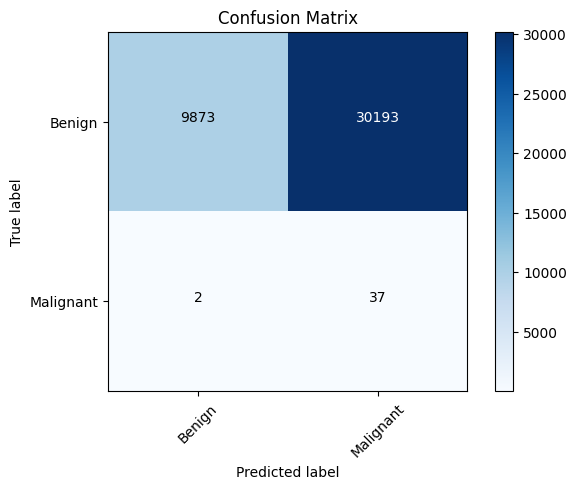

In [14]:
# Get the true labels and predicted labels for the test data
y_true = test_generator.classes  # True labels
y_pred = cnn_model.predict(test_generator)  # Predicted probabilities
y_pred_classes = (y_pred > 0.0009).astype(int)  # Convert probabilities to class labels (0 or 1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Define class labels for the confusion matrix
class_labels = ['Benign', 'Malignant']

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(cm, class_labels)

In [15]:
df = pd.read_csv('dataset/train-metadata.csv')
malignant_rows = df[df['target'] == 1]

/tmp/ipykernel_23/688459233.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset/train-metadata.csv')


In [16]:
malignant_rows

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
387,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,IL_7881385,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683
935,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,IL_5240575,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590
1245,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,IL_1702337,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170
1846,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,IL_3266850,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270
3478,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,IL_2429082,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396165,ISIC_9877311,1,IP_4717387,50.0,female,posterior torso,8.16,TBP tile: close-up,3D: XP,17.351658,...,IL_8242602,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,NaN,NaN,NaN,NaN,99.197656
398671,ISIC_9941636,1,IP_7607582,60.0,female,posterior torso,5.65,TBP tile: close-up,3D: XP,21.990980,...,IL_6366837,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,99.985530
399936,ISIC_9972649,1,IP_9181133,60.0,male,lower extremity,8.51,TBP tile: close-up,3D: white,19.003400,...,IL_7739568,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,86.048290
399943,ISIC_9972877,1,IP_8877928,65.0,female,lower extremity,12.08,TBP tile: close-up,3D: white,23.465230,...,IL_7206529,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma Invasive,"Melanoma Invasive, Superficial spreading",NaN,<1/mm^2,0.6,99.786690


# This code is responsible for:
- 1. Finding the matching row in the metadata CSV for the images in the malignant folder.
- 2. Predicting the label using the previously trained model.
- 3. Adding the prediction to the already existing CSV file.

In [17]:
malignant_image_paths = os.listdir('/kaggle/working/images/malignant')

for image_path in malignant_image_paths:
    filename = os.path.basename(image_path)  # Get the filename from the path
    isic_id = filename.split('.')[0]  # Extract the isic_id (assuming it's before the extension)

    # Find the matching row in the DataFrame
    matching_row_index = malignant_rows[malignant_rows['isic_id'] == isic_id].index[0]

    full_image_path = os.path.join('/kaggle/working/images/malignant', image_path)
    # Load and Preprocess the image
    img = image.load_img(full_image_path, target_size=(128, 128))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    # Get Prediction
    ypred = cnn_model.predict(x, verbose = 0)[0][0]

    # Add ypred to the corresponding row in the DataFrame
    malignant_rows.loc[matching_row_index, 'ypred'] = ypred

/tmp/ipykernel_23/3800138545.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malignant_rows.loc[matching_row_index, 'ypred'] = ypred


# This code creates a new column named 'ypred' in the CSV file, 
# which stores the confidence values predicted by the model for each image.


In [18]:
filtered_rows = malignant_rows[malignant_rows['ypred'].notna()]

In [19]:
len(filtered_rows)

354

# You need to run the next codeblocks
- If you only want the one row prediction demo, you only need to run the next 2 blocks

# This function is responsible for:
- Finding images in the benign folder.
- Predicting their labels using the previously trained model.l.


In [51]:
def get_benigns_with_predictions(metadata_file_path, benign_folder_path, cnn_model, max_rows=354, target_size=(128, 128), target = 0):
    # Read the metadata CSV file
    metadata_df = pd.read_csv(metadata_file_path)
    
    # Filter rows where target = 0
    filtered_df = metadata_df[metadata_df['target'] == target]
    
    # Placeholder for valid rows and predictions
    valid_rows = []
    ypred_list = []
    
    for _, row in filtered_df.iterrows():
        isic_id = row['isic_id']
        image_path = os.path.join(benign_folder_path, f"{isic_id}.jpg")
        
        if os.path.isfile(image_path):  # Check if the image exists
            # Load and preprocess the image
            img = load_img(image_path, target_size=target_size)  # Resize image
            img_array = img_to_array(img)  # Convert to array
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
            img_array = img_array / 255.0  # Normalize the image
            
            # Predict using the model
            ypred = cnn_model.predict(img_array, verbose=0)[0][0]  # Get the prediction (assuming binary classification)
            
            # Append row and prediction
            valid_rows.append(row)
            ypred_list.append(ypred)
        
        if len(valid_rows) == max_rows:  # Break when max_rows is reached
            break
    
    # Create a DataFrame from valid rows
    result_df = pd.DataFrame(valid_rows)
    
    # Add predictions as a new column
    result_df['ypred'] = ypred_list
    
    return result_df


In [52]:
traindatas = ['age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'ypred']

In [54]:
# Example usage:
metadata_file_path = 'dataset/train-metadata.csv'
benign_folder_path = '/kaggle/working/images/benign'
benign_rows_with_predictions = get_benigns_with_predictions(metadata_file_path, benign_folder_path, cnn_model, target = 0)

/tmp/ipykernel_23/759067326.py:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(metadata_file_path)


In [55]:
benign_rows_with_predictions

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,ypred
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,0.002245
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0.016615
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0.000858
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,0.061500
6,ISIC_0051648,0,IP_0218255,65.0,male,upper extremity,3.74,TBP tile: close-up,3D: XP,14.319188,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.918133,0.006467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,ISIC_0082985,0,IP_5961877,75.0,male,anterior torso,5.91,TBP tile: close-up,3D: XP,19.519320,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999990,0.006000
393,ISIC_0083007,0,IP_5450983,80.0,male,upper extremity,3.68,TBP tile: close-up,3D: white,22.945740,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999930,0.001349
395,ISIC_0083088,0,IP_5869016,60.0,female,posterior torso,2.76,TBP tile: close-up,3D: white,23.349670,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,98.851140,0.004153
396,ISIC_0083114,0,IP_6458452,40.0,male,anterior torso,2.50,TBP tile: close-up,3D: XP,21.229390,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.000163


In [56]:
merged_df = pd.concat([filtered_rows, benign_rows_with_predictions], ignore_index=True)

In [57]:
merged_df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,ypred
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683,0.027825
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,0.011084
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,0.015968
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,0.001818
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846,0.003625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,ISIC_0082985,0,IP_5961877,75.0,male,anterior torso,5.91,TBP tile: close-up,3D: XP,19.519320,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999990,0.006000
704,ISIC_0083007,0,IP_5450983,80.0,male,upper extremity,3.68,TBP tile: close-up,3D: white,22.945740,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999930,0.001349
705,ISIC_0083088,0,IP_5869016,60.0,female,posterior torso,2.76,TBP tile: close-up,3D: white,23.349670,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,98.851140,0.004153
706,ISIC_0083114,0,IP_6458452,40.0,male,anterior torso,2.50,TBP tile: close-up,3D: XP,21.229390,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.000163


In [58]:
test_df = pd.read_csv('/kaggle/working/dataset/test-metadata.csv')

In [59]:
print(test_df)

        isic_id  patient_id  age_approx     sex anatom_site_general  \
0  ISIC_0015657  IP_6074337        45.0    male     posterior torso   
1  ISIC_0015729  IP_1664139        35.0  female     lower extremity   
2  ISIC_0015740  IP_7142616        65.0    male     posterior torso   

   clin_size_long_diam_mm          image_type tbp_tile_type  tbp_lv_A  \
0                    2.70  TBP tile: close-up        3D: XP  22.80433   
1                    2.52  TBP tile: close-up        3D: XP  16.64867   
2                    3.16  TBP tile: close-up        3D: XP  24.25384   

   tbp_lv_Aext  ...  tbp_lv_radial_color_std_max  tbp_lv_stdL  tbp_lv_stdLExt  \
0    20.007270  ...                     0.304827     1.281532        2.299935   
1     9.657964  ...                     0.000000     1.271940        2.011223   
2    19.937380  ...                     0.230742     1.080308        2.705857   

   tbp_lv_symm_2axis  tbp_lv_symm_2axis_angle   tbp_lv_x     tbp_lv_y  \
0           0.479339    

In [60]:
print(test_df.columns)

Index(['isic_id', 'patient_id', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution', 'copyright_license'],
      dtype='object')


In [61]:
# Select the columns in traindatas from merged_df
selected_df = merged_df[traindatas]

# Add a new column 'ypred_label' where the first 354 rows are 1, and the rest are 0
selected_df['ypred_label'] = 0
selected_df.loc[:353, 'ypred_label'] = 1  # First 354 rows (index 0 to 353)

/tmp/ipykernel_23/1991837609.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['ypred_label'] = 0


In [62]:
selected_df

,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,ypred,ypred_label
0,80.0,female,anterior torso,9.27,3D: XP,18.093368,13.054772,19.090458,21.211776,26.302386,...,3.514434,5.464301,2.717044,0.472358,0,61.956005,1180.003540,-77.904053,0.027825,1
1,75.0,male,head/neck,3.88,3D: white,26.187010,21.394010,25.553420,24.914770,36.588750,...,0.549971,1.604156,2.798056,0.576744,15,54.423520,1675.860000,-37.749880,0.011084,1
2,80.0,male,anterior torso,6.55,3D: white,33.480140,24.249430,26.160100,25.295430,42.488470,...,1.340916,1.539307,3.697858,0.546485,155,84.834820,1441.758000,-60.321040,0.015968,1
3,60.0,male,upper extremity,5.27,3D: white,25.872050,20.194650,26.805590,28.459890,37.254570,...,1.104453,2.575811,2.600541,0.428889,160,293.127500,1425.201000,50.789730,0.001818,1
4,55.0,male,posterior torso,5.29,3D: white,30.966662,22.008635,24.066940,26.734379,39.219278,...,2.904396,4.122797,3.134399,0.422091,65,-128.599152,1481.198364,13.294312,0.003625,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,75.0,male,anterior torso,5.91,3D: XP,19.519320,14.654330,26.770260,23.537850,33.130810,...,1.331690,2.627031,1.655602,0.190790,50,14.729330,1215.974000,-148.287300,0.006000,0
704,80.0,male,upper extremity,3.68,3D: white,22.945740,17.308950,26.359730,28.134620,34.947710,...,3.372130,5.415947,2.711581,0.241861,75,-232.814600,1378.669000,81.797390,0.001349,0
705,60.0,female,posterior torso,2.76,3D: white,23.349670,20.709690,25.261460,27.717700,34.399830,...,0.000000,2.128586,2.116024,0.314607,45,82.471080,1277.618000,102.703400,0.004153,0
706,40.0,male,anterior torso,2.50,3D: XP,21.229390,12.548430,37.834800,33.500370,43.383860,...,0.746892,3.151448,1.866968,0.241379,60,86.029970,1207.004000,-66.010070,0.000163,0


# This code performs one-hot encoding on non-numeric columns, 
# converting categorical data into a binary matrix.


In [63]:
# Identify numeric and non-numeric columns
numeric_df = selected_df.select_dtypes(include=[np.number])  # Select numeric columns
non_numeric_df = selected_df.select_dtypes(exclude=[np.number])  # Select non-numeric columns

# One-hot encode the non-numeric columns
encoded_non_numeric_df = pd.get_dummies(non_numeric_df, drop_first=True)

# Merge numeric and encoded columns
final_df = pd.concat([encoded_non_numeric_df, numeric_df], axis=1)

In [64]:
len(final_df)

708

In [65]:
rows_with_nan = final_df.isna().any(axis=1).sum()
print(f"Number of rows with at least one NaN value: {rows_with_nan}")

Number of rows with at least one NaN value: 6


In [66]:
clean_df = final_df.dropna()

# Step 1: Prepare features (X) and target (y)
X = clean_df.drop(columns=['ypred_label'])  # Drop 'ypred_label' column as it's the target
y = clean_df['ypred_label']  # 'ypred_label' is the target column

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize Random Forest Classifier
model = RandomForestClassifier(random_state=42)

# Step 4: Train the model
model.fit(X_train, y_train)

# Step 5: Predict on test data
y_pred = model.predict(X_test)

# Step 6: Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8581560283687943


In [67]:
len(clean_df)

702

ROC-AUC Score: 0.9279352226720647


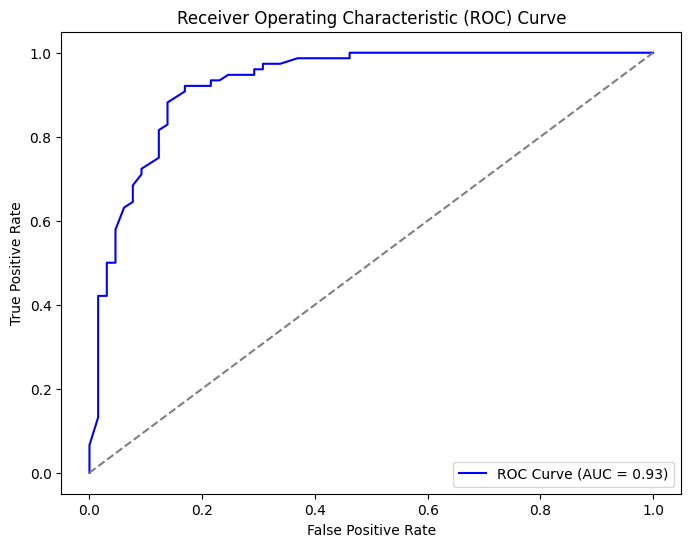

In [68]:
# Get predicted probabilities (not labels) for the positive class
# The model's `predict_proba` method returns probabilities for both classes
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (class 1)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

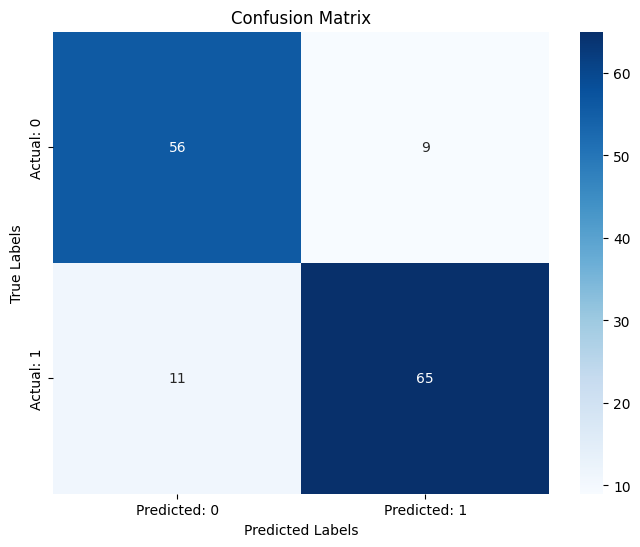

Confusion Matrix:
[[56  9]
 [11 65]]


In [69]:
# Predict the labels (not probabilities) using the model
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

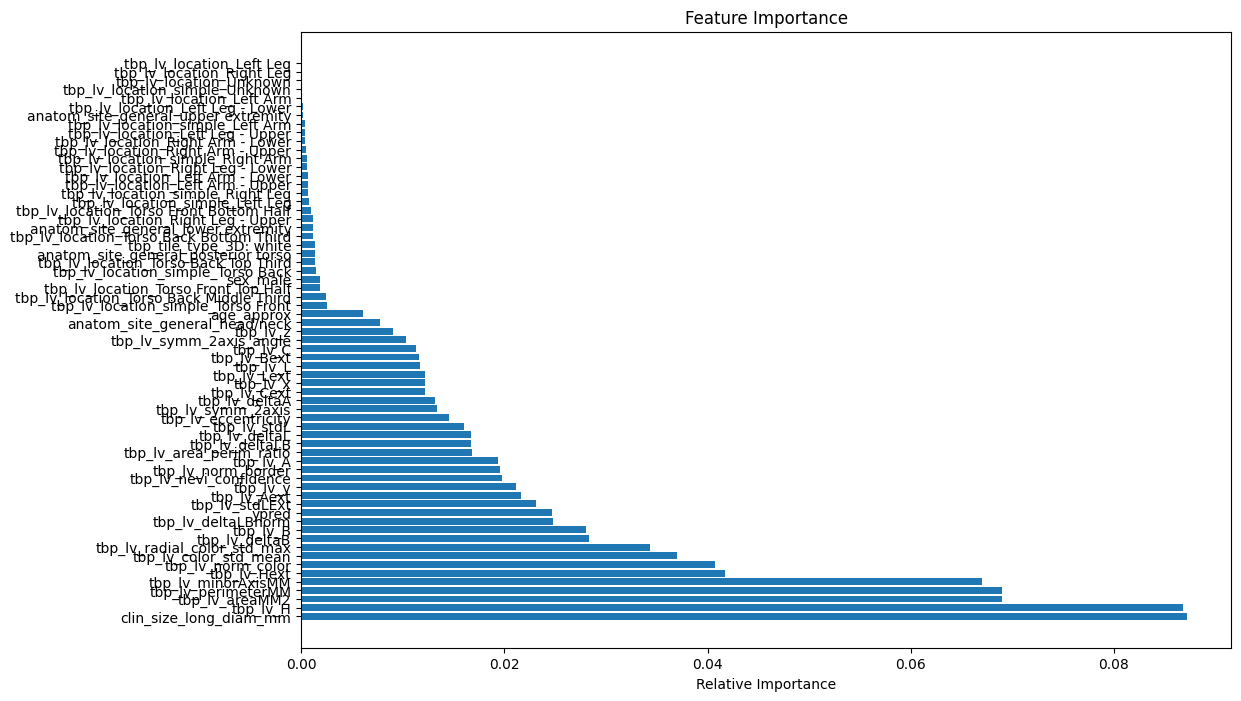

In [70]:
importances = model.feature_importances_

# Assuming X_train is a DataFrame, get the column names (features)
features = X_train.columns

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plotting the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importance")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), features[indices])
plt.xlabel("Relative Importance")
plt.show()

# These code blocks are used to test the model on the previously selected 10% of images, 
# which constitute the test dataset.


In [71]:
test_malignant_rows = df[df['target'] == 1]

# This code functions similarly to the previous one but operates on the train datasets instead.


In [72]:
malignant_image_paths = os.listdir('/kaggle/working/Test/malignant_test')


for image_path in malignant_image_paths:
    filename = os.path.basename(image_path)  # Get the filename from the path
    isic_id = filename.split('.')[0]  # Extract the isic_id (assuming it's before the extension)

    # Find the matching row in the DataFrame
    matching_row_index = test_malignant_rows[test_malignant_rows['isic_id'] == isic_id].index[0]

    full_image_path = os.path.join('/kaggle/working/Test/malignant_test', image_path)
    # Load and Preprocess the image
    img = image.load_img(full_image_path, target_size=(128, 128))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    # Get Prediction
    ypred = cnn_model.predict(x, verbose = 0)[0][0]

    # Add ypred to the corresponding row in the DataFrame
    test_malignant_rows.loc[matching_row_index, 'ypred'] = ypred

/tmp/ipykernel_23/3694905064.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_malignant_rows.loc[matching_row_index, 'ypred'] = ypred


In [73]:
# Count rows where ypred is not NaN
count_not_nan = test_malignant_rows['ypred'].notna().sum()

print(f"Number of rows where ypred is not NaN: {count_not_nan}")

Number of rows where ypred is not NaN: 39


In [74]:
# Select rows where ypred is not NaN
test_malignant_rows = test_malignant_rows[test_malignant_rows['ypred'].notna()]

test_malignant_rows

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,ypred
5673,ISIC_0211092,1,IP_2203964,65.0,male,posterior torso,2.52,TBP tile: close-up,3D: white,18.735590,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,99.999869,0.028022
15163,ISIC_0445144,1,IP_0822819,60.0,male,head/neck,9.20,TBP tile: close-up,3D: XP,18.003523,...,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),"Melanoma, NOS",NaN,NaN,NaN,NaN,70.703703,0.084340
20007,ISIC_0565021,1,IP_3026867,65.0,male,posterior torso,6.49,TBP tile: close-up,3D: white,32.303411,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.992728,0.001218
26382,ISIC_0719839,1,IP_4849578,50.0,female,anterior torso,7.87,TBP tile: close-up,3D: XP,24.146599,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.996674,0.001358
36354,ISIC_0968965,1,IP_2456971,60.0,male,head/neck,2.56,TBP tile: close-up,3D: white,22.871487,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,95.601445,0.006326
41888,ISIC_1105843,1,IP_3026867,65.0,male,upper extremity,6.30,TBP tile: close-up,3D: white,15.686199,...,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma in situ,NaN,NaN,NaN,NaN,99.999690,0.000463
67519,ISIC_1741809,1,IP_8170065,60.0,male,head/neck,1.76,TBP tile: close-up,3D: white,37.682790,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,94.806970,0.017575
90669,ISIC_2318247,1,IP_2732171,65.0,male,head/neck,2.95,TBP tile: close-up,3D: white,30.404084,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,99.900037,0.007115
107835,ISIC_2746016,1,IP_8352314,65.0,female,lower extremity,7.01,TBP tile: close-up,3D: white,25.856600,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.999860,0.011257
108615,ISIC_2764227,1,IP_9181133,60.0,male,head/neck,1.72,TBP tile: close-up,3D: white,30.155960,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,97.851100,0.011656


In [75]:
# Define the directory path
directory_path = '/kaggle/working/Test/benign_test'

# List all files in the directory
files = os.listdir(directory_path)

# Filter for image files (common extensions: jpg, png, jpeg, etc.)
image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'))]

# Count the number of image files
num_images = len(image_files)

print(f"Number of images in {directory_path}: {num_images}")

Number of images in /kaggle/working/Test/benign_test: 40066


In [76]:
# Example usage:
metadata_file_path = 'dataset/train-metadata.csv'
benign_folder_path = '/kaggle/working/Test/benign_test'
test_benign_rows = get_benigns_with_predictions(metadata_file_path, benign_folder_path, cnn_model, max_rows = 40000, target = 0)

/tmp/ipykernel_23/759067326.py:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(metadata_file_path)


In [77]:
test_merged_df = pd.concat([test_benign_rows, test_malignant_rows], ignore_index=True)

In [78]:
test_df = test_merged_df[traindatas]

In [79]:
# Create a new column 'ylabel' and set all values to 0
test_df['ypred_label'] = 0

# Update the last 39 rows of 'ylabel' to 1
test_df.loc[test_merged_df.index[-39:], 'ypred_label'] = 1

/tmp/ipykernel_23/847438960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ypred_label'] = 0


In [80]:
numeric_df = test_df.select_dtypes(include=[np.number])  # Select numeric columns
non_numeric_df = test_df.select_dtypes(exclude=[np.number])  # Select non-numeric columns

# One-hot encode the non-numeric columns
encoded_non_numeric_df = pd.get_dummies(non_numeric_df, drop_first=False)

# Merge numeric and encoded columns
hotencodedtest_df = pd.concat([encoded_non_numeric_df, numeric_df], axis=1)

In [81]:
# Columns used during training
train_columns = X_train.columns  # X_train is the feature set used in training
columns_to_keep = list(train_columns) + ['ypred_label']

hotencodedtest_df = hotencodedtest_df[columns_to_keep]

cleantest_df = hotencodedtest_df.dropna()

Accuracy: 0.8718

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     39719
           1       0.01      0.82      0.01        39

    accuracy                           0.87     39758
   macro avg       0.50      0.85      0.47     39758
weighted avg       1.00      0.87      0.93     39758


Confusion Matrix:
[[34631  5088]
 [    7    32]]


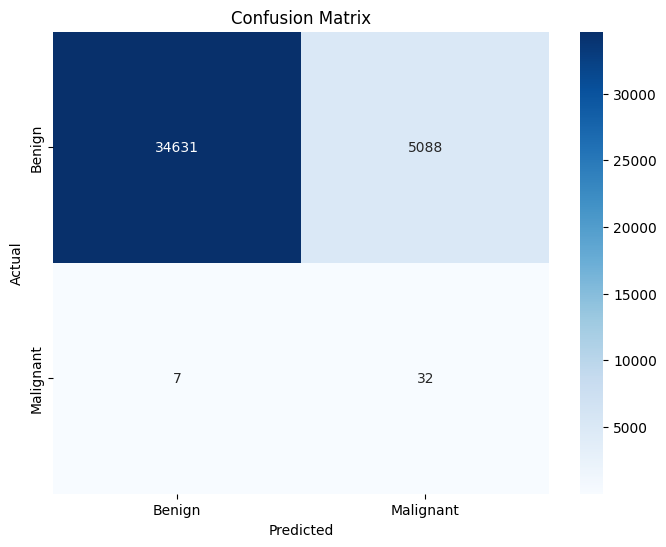

In [82]:
X_test = cleantest_df.drop(columns=['ypred_label'])  # Assuming 'ypred_label' is the target column
y_test = cleantest_df['ypred_label']

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# As we can see, using the datas in the csv file significantly improved our model, we predicted most of the malignant cases as malignant, while we mispredicted only about 13% of the benign cases.

# For using the final model, you need to run the cells below.
- Also you need to run a few other cells above to make it work, they are labled as: You need to run this

In [83]:
!pip install gdown

# Step 1: Download the model from Google Drive
url = 'https://drive.google.com/uc?id=1wc4varBX3uA0e4Ac_VxrHwXHggVz2HeO'
output = 'random_forest_model.joblib'
gdown.download(url, output, quiet=False)

# Step 2: Load model
rf_model = load('random_forest_model.joblib')
print("Modell betöltve.")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Downloading...
From: https://drive.google.com/uc?id=1wc4varBX3uA0e4Ac_VxrHwXHggVz2HeO
To: /kaggle/working/random_forest_model.joblib
100%|██████████| 892k/892k [00:00<00:00, 107MB/s]

Modell betöltve.


# You can predict for bening and malignant images, but you need to change the X_folder_path to the corresponding one. Also you need to change the target number.
- If you want benign, than you need target = 0
- For malignant images you need target = 1

In [84]:
metadata_file_path = 'dataset/train-metadata.csv'
benign_folder_path = '/kaggle/working/Test/benign_test'
malignant_folder_path = '/kaggle/working/Test/malignant_test'
test_rows = get_benigns_with_predictions(metadata_file_path, malignant_folder_path, cnn_model, max_rows = 1, target = 1)


/tmp/ipykernel_23/759067326.py:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(metadata_file_path)


In [85]:
test_df = test_rows[traindatas]

# Identify numeric and non-numeric columns
numeric_df = test_df.select_dtypes(include=[np.number])  # Select numeric columns
non_numeric_df = test_df.select_dtypes(exclude=[np.number])  # Select non-numeric columns

# One-hot encode the non-numeric columns
encoded_non_numeric_df = pd.get_dummies(non_numeric_df, drop_first=False)

# Merge numeric and encoded columns
final_df = pd.concat([encoded_non_numeric_df, numeric_df], axis=1)
#clean_df = final_df.dropna()

expected_columns = rf_model.feature_names_in_
missing_columns = set(expected_columns) - set(final_df.columns)
for col in missing_columns:
    final_df[col] = 0
final_df = final_df[expected_columns]



pred = rf_model.predict(final_df)

if (pred[0] == 0):
    print("The image is benign!")
else:
    print("The image is malignant!")

The image is benign!
